## Predicting Twitter sentiments for Self-driving cars

Based on given train data, we need to classify tweets about driverless cars as from very positive to very negative. 

5 - very positive

4 - slightly positive

3 - neutral

2 - slightly negative

1 - very negative

There are train and test datasets.

#### Acknowledgements

Thanks crowdflower.com, for providing dataset.

In [620]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf


from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.ml.feature import HashingTF, IDF

# these imports are how we build and manager our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import IntegerType

import pandas as pd
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [621]:
## constants
DATA_NAME = "/home/ds/notebooks/datasets/Twitter_data/train.csv"
APP_NAME = "Sentiment Analysis with tweets"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 200
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

## Loading Data with Spark

In [622]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

In [623]:
tweets_data = sqlContext.read.csv(DATA_NAME, header=True, mode="DROPMALFORMED")

In [624]:
tweets_data.show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        5|@manjulamartin @K...|
|        5|I want a Google d...|
|        5|@Oatmeal @google ...|
|        5|SO MUCH AWESOME! ...|
|        5|@google is making...|
|        5|You could call a ...|
|        5|Ì¢‰âÂÒ@Marketpla...|
|        5|Driverless taxis ...|
|        5|This whole @googl...|
|        5|Google's New Driv...|
|        5|Riding in a drive...|
|        5|This is the futur...|
|        5|@NicoleLapin The ...|
|        5|This is why we ne...|
|        5|Google developed ...|
|        5|@WOKVNews @jax_fl...|
|        5|They're coming ou...|
|        5|I want a driverle...|
|        5|Driverless cars c...|
|        5|#SKYNET Ì¢‰âÂÒ@S...|
+---------+--------------------+
only showing top 20 rows



In [625]:
tweets_data.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)



In [394]:
tweets_data.count()

967

In [395]:
tweets_data = tweets_data.dropna()

In [396]:
tweets_data.count()

967

As data analysis shows that there are no null records also data is in texual format we can not perform prediction modelling on data unless we convert that data to numeric values. we have to extract features from text data to analyze it. Lets vizualize data first

## Data Visualization

In [521]:
#from pyspark.sql.types import IntegerType
#tweets_data = tweets_data.withColumn("sentiment", tweets_data["sentiment"].cast(IntegerType()))

In [557]:
tweets_data.count()

967

In [397]:
# Define function to handle sentiments
#def tweeter_sentiment(x):
    #if x > 3:  #sentiments with very positive, slightly positive
     #   return 2
    #elif x < 3: #sentiments with slightly negative, very negative
        #return 1
    #else:
        #return 0 #sentiments with neutral

In [713]:
#func_udf = udf(tweeter_sentiment, IntegerType())
#tweets_data = tweets_data.withColumn('sentiment_encoded',func_udf(tweets_data['sentiment'].cast(IntegerType())))
tweets_data = tweets_data.withColumn('sentiment_encoded',tweets_data['sentiment'].cast(IntegerType()))

In [714]:
tweets_data.show(5)

+---------+--------------------+-----------------+
|sentiment|                text|sentiment_encoded|
+---------+--------------------+-----------------+
|        5|@manjulamartin @K...|                5|
|        5|I want a Google d...|                5|
|        5|@Oatmeal @google ...|                5|
|        5|SO MUCH AWESOME! ...|                5|
|        5|@google is making...|                5|
+---------+--------------------+-----------------+
only showing top 5 rows



In [715]:
statuses = tweets_data.groupBy('sentiment_encoded').count().show()

+-----------------+-----+
|sentiment_encoded|count|
+-----------------+-----+
|                1|   23|
|                3|  595|
|                5|   57|
|                4|  177|
|                2|  115|
+-----------------+-----+



[Row(sentiment='3', count=595), Row(sentiment='5', count=57), Row(sentiment='1', count=23), Row(sentiment='4', count=177), Row(sentiment='2', count=115)]
['3', '5', '1', '4', '2']
['neutral', 'very positive', 'very negative', 'slightly positive', 'slightly negative']


([<matplotlib.axis.XTick at 0x7f0fb8069a90>,
 <a list of 5 Text xticklabel objects>)

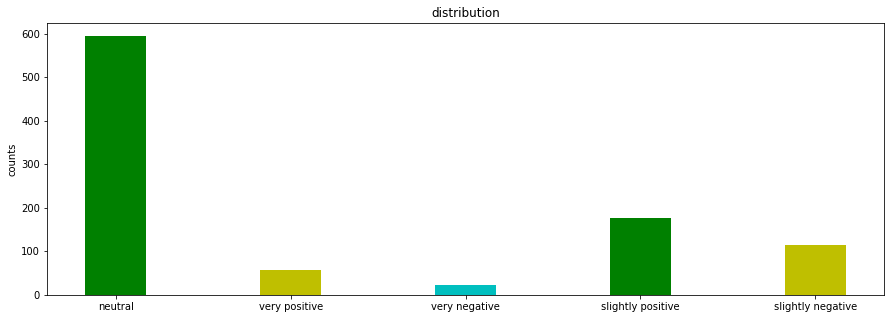

In [717]:
plt.rcParams['figure.figsize'] = (15, 5)
 
#statuses = tweets_data.groupBy('sentiment_encoded').count().collect()
statuses = tweets_data.groupBy('sentiment').count().collect()
print(statuses)
categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
display_label = []

#for item in categories:
    #if item == 1:
        #display_label.append('negative')
    #elif item == 2:
       # display_label.append('positive')
    #else:
        #display_label.append('neutral')
print(categories)
for item in categories:
    if item == '5':
        display_label.append('very positive')
    elif item == '4':
        display_label.append('slightly positive')
    elif item == '3':
        display_label.append('neutral')
    elif item == '2':
        display_label.append('slightly negative')
    else:
        display_label.append('very negative')
        
print(display_label)        
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='gyc')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind, display_label)

The above graph shows that sentiment for self driving car tweets is more of neutral compared to positive or negative. Lets find out some features for predictive modelling on the twitter data

## Feature Extraction

Lets try different techniques for feature engineering like word2vec or Tf/Idf to make data ready for predictive modelling

### Word2Vec

In [718]:
tokenized_data = Tokenizer(inputCol="text", outputCol="tokenized_text").transform(tweets_data)

In [719]:
word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenized_data)
w2vdf=word2Vec.transform(tokenized_data)

In [720]:
w2vdf.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment_encoded: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [721]:
w2vdf.select('sentiment','text','tokenized_text','w2v_vector').show()

+---------+--------------------+--------------------+--------------------+
|sentiment|                text|      tokenized_text|          w2v_vector|
+---------+--------------------+--------------------+--------------------+
|        5|@manjulamartin @K...|[@manjulamartin, ...|[0.00195620217564...|
|        5|I want a Google d...|[i, want, a, goog...|[0.01613896682101...|
|        5|@Oatmeal @google ...|[@oatmeal, @googl...|[0.01142727420665...|
|        5|SO MUCH AWESOME! ...|[so, much, awesom...|[0.00425823115898...|
|        5|@google is making...|[@google, is, mak...|[0.00704800314916...|
|        5|You could call a ...|[you, could, call...|[0.00506992266807...|
|        5|Ì¢‰âÂÒ@Marketpla...|[ì¢‰ââò@marketpl...|[0.00591101296330...|
|        5|Driverless taxis ...|[driverless, taxi...|[0.01109385670618...|
|        5|This whole @googl...|[this, whole, @go...|[0.00681427969935...|
|        5|Google's New Driv...|[google's, new, d...|[0.00581081371961...|
|        5|Riding in a dr

### TF/IDF

In [722]:
hashingTF = HashingTF(inputCol="tokenized_text", outputCol="tfidf_vector", numFeatures=20)
featurizedData = hashingTF.transform(tokenized_data)

In [723]:
idf = IDF(inputCol="tfidf_vector", outputCol="features")
idfModel = idf.fit(featurizedData)
tfidf_df = idfModel.transform(featurizedData)

In [724]:
tfidf_df.show(5)

+---------+--------------------+-----------------+--------------------+--------------------+--------------------+
|sentiment|                text|sentiment_encoded|      tokenized_text|        tfidf_vector|            features|
+---------+--------------------+-----------------+--------------------+--------------------+--------------------+
|        5|@manjulamartin @K...|                5|[@manjulamartin, ...|(20,[0,2,3,4,6,7,...|(20,[0,2,3,4,6,7,...|
|        5|I want a Google d...|                5|[i, want, a, goog...|(20,[0,9,10,12,16...|(20,[0,9,10,12,16...|
|        5|@Oatmeal @google ...|                5|[@oatmeal, @googl...|(20,[0,1,3,4,9,10...|(20,[0,1,3,4,9,10...|
|        5|SO MUCH AWESOME! ...|                5|[so, much, awesom...|(20,[0,2,4,5,6,8,...|(20,[0,2,4,5,6,8,...|
|        5|@google is making...|                5|[@google, is, mak...|(20,[0,1,8,10,16,...|(20,[0,1,8,10,16,...|
+---------+--------------------+-----------------+--------------------+-----------------

## Data Modelling

### Random Forest Classifier

As we tried different ways for feature extraction, lets try to perform random forest classifier on those datasets to see which one performs better

#### Random Forest with Word2Vec

In [727]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="sentiment", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=5).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [728]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [729]:
predictions.select('sentiment','w2v_vector','probability','prediction','predictedLabel').show(10)

+---------+--------------------+--------------------+----------+--------------+
|sentiment|          w2v_vector|         probability|prediction|predictedLabel|
+---------+--------------------+--------------------+----------+--------------+
|        1|[0.00788420691969...|[0.70060010928181...|       0.0|             3|
|        1|[0.00346490017060...|[0.48143189791398...|       0.0|             3|
|        1|[0.00354269497936...|[0.47950792966792...|       0.0|             3|
|        1|[0.00801549779716...|[0.56599194509255...|       0.0|             3|
|        1|[0.00495200723697...|[0.50674446432616...|       0.0|             3|
|        2|[0.00483414915177...|[0.56832170403602...|       0.0|             3|
|        2|[0.00671476894058...|[0.63137778109392...|       0.0|             3|
|        2|[0.00264964997009...|[0.49337217972828...|       0.0|             3|
|        2|[-0.0014114782639...|[0.53884055254912...|       0.0|             3|
|        2|[0.00561993133887...|[0.59094

In [730]:
predictions.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment_encoded: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)
 |-- indexedLabel: double (nullable = true)
 |-- indexedFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)
 |-- predictedLabel: string (nullable = true)



In [731]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.369048
Accuracy = 0.630952


In [732]:
pd.DataFrame(confusion_matrix(predictions.select('sentiment').collect(), 
             predictions.select('predictedLabel').collect()),
             columns = display_label, 
             index= display_label)

,neutral,very positive,very negative,slightly positive,slightly negative
neutral,0,0,5,0,0
very positive,0,0,21,0,0
very negative,0,0,106,0,0
slightly positive,0,0,28,0,0
slightly negative,0,0,8,0,0


#### Random Forest with TF/IDF

In [733]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="sentiment", outputCol="indexedLabel").fit(tfidf_df)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="tfidf_vector", outputCol="indexedFeatures", maxCategories=5).fit(tfidf_df)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData_tf, testData_tf) = tfidf_df.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [734]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData_tf)

# Make predictions.
predictions = model.transform(testData_tf)

In [735]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.364583
Accuracy = 0.635417


In [736]:
pd.DataFrame(confusion_matrix(predictions.select('sentiment').collect(), 
             predictions.select('predictedLabel').collect()),
             columns = display_label, 
             index= display_label)

,neutral,very positive,very negative,slightly positive,slightly negative
neutral,0,0,5,0,0
very positive,0,0,17,0,0
very negative,0,0,122,0,0
slightly positive,0,0,37,0,0
slightly negative,0,0,11,0,0


It looks like Tf/idf data perform better with Random Forest compared to word2vec

### Logistic Regression

#### Logistic regression with word2vec

In [737]:
lr = LogisticRegression(featuresCol="w2v_vector", labelCol="sentiment_encoded",predictionCol="prediction", maxIter=10,
                        regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
lrModel = lr.fit(trainingData)
# Make predictions.
predictions = lrModel.transform(testData)

In [738]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.369048
Accuracy = 0.630952


In [739]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())
# Create 5-fold CrossValidator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_encoded", predictionCol="prediction", metricName="accuracy")
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model

accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.369048
Accuracy = 0.630952


#### Logistic Regression with TF/IDF

In [740]:
lr = LogisticRegression(featuresCol="features", labelCol="sentiment_encoded",predictionCol="prediction", maxIter=10,
                        regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
lrModel_tf = lr.fit(trainingData_tf)
# Make predictions.
predictions = lrModel_tf.transform(testData_tf)

In [741]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.364583
Accuracy = 0.635417


In [742]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())
# Create 5-fold CrossValidator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_encoded", predictionCol="prediction", metricName="accuracy")
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData_tf)

predictions = cvModel.transform(testData_tf)
# Evaluate best model

accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.364583
Accuracy = 0.635417


In [743]:
pd.DataFrame(confusion_matrix(predictions.select('sentiment_encoded').collect(), 
             predictions.select('prediction').collect()),
             columns = display_label, 
             index= display_label)

,neutral,very positive,very negative,slightly positive,slightly negative
neutral,0,0,5,0,0
very positive,0,0,17,0,0
very negative,0,0,122,0,0
slightly positive,0,0,37,0,0
slightly negative,0,0,11,0,0


### Naive Bayes Classifier

In [749]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="sentiment_encoded", featuresCol="features", smoothing=1)
model = nb.fit(trainingData_tf)
predictions_nb = model.transform(testData_tf)

In [750]:
predictions_nb.show(5)

+---------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|sentiment|                text|sentiment_encoded|      tokenized_text|        tfidf_vector|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        1|Also, cars with d...|                1|[also,, cars, wit...|(20,[0,1,4,5,8,10...|(20,[0,1,4,5,8,10...|[-34.991220382687...|[0.01345379266100...|       2.0|
|        1|Driverless Cars: ...|                1|[driverless, cars...|(20,[0,1,4,5,6,8,...|(20,[0,1,4,5,6,8,...|[-34.326147156903...|[0.02871811555264...|       2.0|
|        1|Driverless cars. ...|                1|[driverless, cars...|(20,[0,9,12,14,15...|(20,[0,9,12,14,15...|[-21.013147791562...|[0.03823751585407...|       2.0

In [751]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_nb)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.911458
Accuracy = 0.0885417


In [752]:
pd.DataFrame(confusion_matrix(predictions_nb.select('sentiment_encoded').collect(), 
             predictions_nb.select('prediction').collect()),
             columns = display_label, 
             index= display_label)

,neutral,very positive,very negative,slightly positive,slightly negative
neutral,0,5,0,0,0
very positive,0,17,0,0,0
very negative,0,122,0,0,0
slightly positive,0,37,0,0,0
slightly negative,0,11,0,0,0


### PCA

##### PCA with word2vec data and Random Forest

In [753]:
pca = PCA(k=100, inputCol="w2v_vector", outputCol="pcaFeatures")
model = pca.fit(w2vdf)

result = model.transform(w2vdf)

In [762]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="sentiment", outputCol="indexedLabel").fit(result)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="pcaFeatures", outputCol="indexedFeatures", maxCategories=4).fit(result)
    
# Split the data into training and validation sets (30% held out for testing)
(pca_trainingData, pca_testData) = result.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [763]:
# Train model.  This also runs the indexers.
pca_model = pipeline.fit(pca_trainingData)
# Make predictions.
pca_predictions = pca_model.transform(pca_testData)

In [764]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pca_predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.429319
Accuracy = 0.570681


In [765]:
pd.DataFrame(confusion_matrix(pca_predictions.select('sentiment').collect(), 
             pca_predictions.select('predictedLabel').collect()),
             columns = display_label, 
             index= display_label)

,neutral,very positive,very negative,slightly positive,slightly negative
neutral,0,0,5,0,0
very positive,0,0,26,0,0
very negative,0,0,109,0,0
slightly positive,0,0,41,0,0
slightly negative,0,0,10,0,0


##### PCA with tf/idf data and Random Forest

In [439]:
pca = PCA(k=10, inputCol="tfidf_vector", outputCol="pcaFeatures")
model = pca.fit(tfidf_df)

result = model.transform(tfidf_df)

In [766]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="sentiment", outputCol="indexedLabel").fit(result)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="pcaFeatures", outputCol="indexedFeatures", maxCategories=4).fit(result)
    
# Split the data into training and validation sets (30% held out for testing)
(pca_trainingData_tf, pca_testData_tf) = result.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [767]:
# Train model.  This also runs the indexers.
pca_model = pipeline.fit(pca_trainingData_tf)
# Make predictions.
pca_predictions_tf = pca_model.transform(pca_testData_tf)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pca_predictions_tf)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.338462
Accuracy = 0.661538


In [769]:
pd.DataFrame(confusion_matrix(pca_predictions_tf.select('sentiment').collect(), 
             pca_predictions_tf.select('predictedLabel').collect()),
             columns = display_label, 
             index= display_label)

,neutral,very positive,very negative,slightly positive,slightly negative
neutral,0,0,3,0,0
very positive,0,0,21,0,0
very negative,0,0,129,0,0
slightly positive,0,0,34,0,0
slightly negative,0,0,7,1,0


##### PCA with tf/idf and Logistic regression

In [772]:
pca_trainingData_tf.show(5)

+---------+--------------------+-----------------+--------------------+--------------------+--------------------+
|sentiment|                text|sentiment_encoded|      tokenized_text|          w2v_vector|         pcaFeatures|
+---------+--------------------+-----------------+--------------------+--------------------+--------------------+
|        1|"""Driver-less ca...|                1|["""driver-less, ...|[0.00421577897903...|[-0.1158061037854...|
|        1|"8:28 AM - The dr...|                1|["8:28, am, -, th...|[0.00465906232737...|[-0.1097614065674...|
|        1|@d3signerd Ì¢‰âÂå...|                1|[@d3signerd, ì¢‰â...|[0.00788420691969...|[-0.1494378231530...|
|        1|@drgitlin yes, I ...|                1|[@drgitlin, yes,,...|[0.00661176691175...|[-0.1431551413024...|
|        1|@google watched t...|                1|[@google, watched...|[0.00477988349040...|[-0.1040094240407...|
+---------+--------------------+-----------------+--------------------+-----------------

In [773]:
lr = LogisticRegression(featuresCol="pcaFeatures", labelCol="sentiment_encoded",predictionCol="prediction", maxIter=10,
                        regParam=0.3, elasticNetParam=0.8, family="multinomial")

In [774]:
# Train model.  This also runs the indexers.
pca_model = lr.fit(pca_trainingData_tf)
# Make predictions.
pca_predictions = pca_model.transform(pca_testData_tf)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pca_predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.338462
Accuracy = 0.661538


#### PCA with Word2Vec and Logistic Regression

In [775]:
pca = PCA(k=10, inputCol="w2v_vector", outputCol="pca_w2v_Features")
model = pca.fit(w2vdf)

result = model.transform(w2vdf)

In [779]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="sentiment_encoded", outputCol="indexedLabel").fit(result)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="pca_w2v_Features", outputCol="indexedFeatures", maxCategories=4).fit(result)
    
# Split the data into training and validation sets (30% held out for testing)
(pca_trainingData, pca_testData) = result.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [780]:
# Train model.  This also runs the indexers.
pca_model = pipeline.fit(pca_trainingData)
pca_predictions = pca_model.transform(pca_testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pca_predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.42132
Accuracy = 0.57868
